In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import base64
from IPython.display import HTML

from tensorflow.keras.applications import vgg19

# Helper Functions

In [ ]:
def plot_image_grid(images,num_rows=1):
    """
    input a list of images and it plots them with num_rows rows."""
    n= len(images)
    num_cols = np.ceil(n/num_rows)
    fig,axes = plt.subplots(ncols=int(num_cols),nrows=int(num_rows))
    axes = axes.flatten()
    fig.set_size_inches((15,15))
    for i,image in enumerate(images):
        axes[i].imshow(image)

def place_video(location_of_video):
    """
    location_of_video: location of mp4 video"""
    video = io.open(location_of_video, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii')))
    

In [ ]:
def load_image(location,target_size=None):
    """
    provide a location and output a numpy image.
    """
    img = Image.open(location)
    if target_size == None:     
        return np.array(img)
    else:
        img = np.array(img.resize(target_size))
        return img



# Main Code

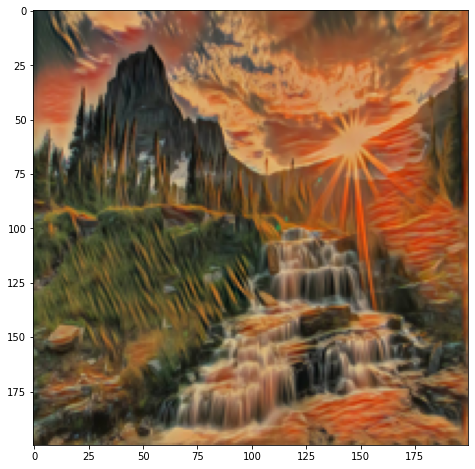

In [ ]:
style_loc = '/content/drive/My Drive/data/main-bg.jpg'
style_image = load_image(style_loc, target_size=(200, 200))
plt.figure(figsize=(20,8))
plt.imshow(style_image)

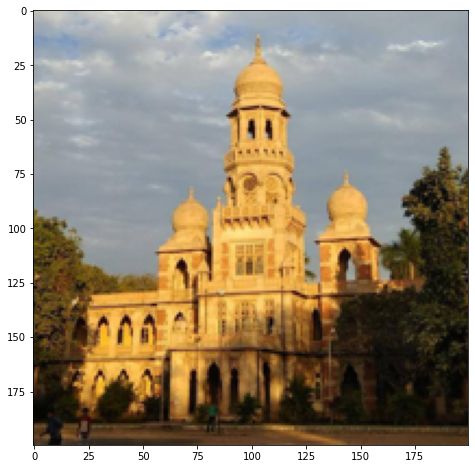

In [ ]:
content_loc = '/content/drive/My Drive/data/content.jpg'
content_image = load_image(content_loc, target_size=(200, 200))
plt.figure(figsize=(20,8))
plt.imshow(content_image)

In [ ]:
model = vgg19.VGG19(include_top=False, weights='imagenet')
model.summary()  

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
processed_style_image = vgg19.preprocess_input(np.expand_dims(style_image, axis=0))
processed_style_image.shape

(1, 200, 200, 3)

In [ ]:
processed_content_image = vgg19.preprocess_input(np.expand_dims(content_image, axis=0))
processed_content_image.shape

(1, 200, 200, 3)

In [ ]:
VGG_Biases = vgg19.preprocess_input(np.zeros(((3))).astype('float'))

In [ ]:
VGG_Biases

array([-103.939, -116.779, -123.68 ])

In [ ]:
def Get_Orignal(output_image):
  unprocessed_img = output_image - VGG_Biases
  unprocessed_img = tf.unstack(unprocessed_img, axis=-1)
  unprocessed_img = tf.stack([unprocessed_img[2], unprocessed_img[1], unprocessed_img[0]], axis=-1)
  final_img = tf.reshape(unprocessed_img, [unprocessed_img.shape[1], unprocessed_img.shape[2], unprocessed_img.shape[3]])
  return final_img.numpy().astype('int')

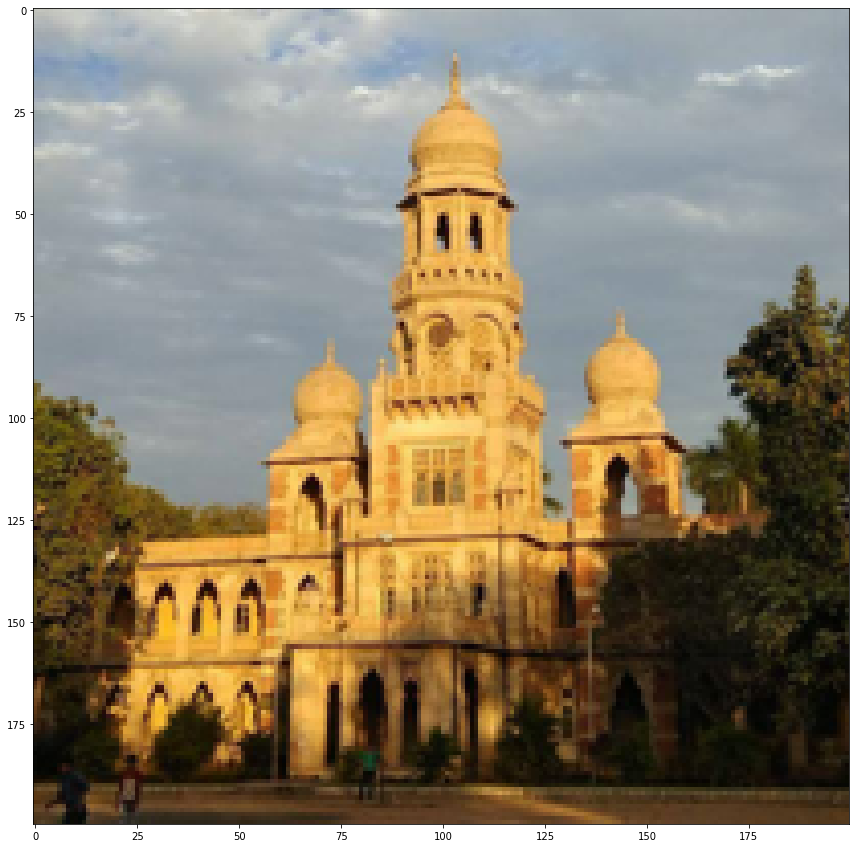

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(Get_Orignal(processed_content_image))

In [ ]:
CONTENT_LAYER = ['block5_conv3']

In [ ]:
STYLE_LAYERS = ['block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4']

In [ ]:
def create_model():
  model = vgg19.VGG19(include_top=False, weights='imagenet') # Load the VGG19 model
  model.trainable = False # Here we don't want to train the model so we set trainable parameter as False
  content_layers = CONTENT_LAYER # This is the list of the layers of the model from which we would want to take content image outputs
  style_layers = STYLE_LAYERS # This is the list of the layers of the model from which we would want to take style image outputs

  output_layers = [model.get_layer(layer).output for layer in (content_layers+style_layers)] # This just takes both style and content layers 
                                                                      # and makes another list and we feed it while creating the model as output layers

  return tf.keras.models.Model(model.input, output_layers) # We return a model with input which we would specify and get the output from 
                                                              # the layers corresepnding to the output_layers list

In [ ]:
model = create_model()

In [ ]:
  content_output = model(processed_content_image)[0] # Here we are taking the 0th element of the output as the content layer is added first in the model outputs
  style_output = model(processed_style_image)[1:] # Here we are taking all the elements except the 0th element which correspond to the style outputs

In [ ]:
def content_loss(content, generated):
  # Here we just take the L2 Norm of the generated image and the content image
  return np.mean(np.square(content - generated))

In [ ]:
def gram_matrix(output):
    first_style_layer = output
    A = tf.reshape(first_style_layer,(-1,first_style_layer.shape[-1])) 
    n = A.shape[0]
    gram_matrix = tf.matmul(A,A,transpose_a=True)
    n=gram_matrix.shape[0]
    return gram_matrix/tf.cast(n,"float32"),n


In [ ]:
# gram_matrix, n = gram_matrix(style_output[2])
# plt.figure(figsize=(10,10))
# plt.imshow(gram_matrix.numpy())

In [ ]:
  def style_loss(style_im, generated_im):
    new_style_gram,gram_num_height = gram_matrix(generated_im)
    base_style_gram,gram_num_height2 = gram_matrix(style_im)
    assert gram_num_height == gram_num_height2
    gram_num_features = new_style_gram.shape[0]
    loss=tf.reduce_sum(tf.square(base_style_gram-new_style_gram)/(4*(gram_num_height**2)*(gram_num_features**2)))
    return loss

In [ ]:
def total_loss(new_image_output,base_content_image_output,base_style_image_output,alpha=.999):
    new_image_styles = new_image_output[len(CONTENT_LAYER):]
    base_image_styles = base_style_image_output[len(CONTENT_LAYER):]
    sty_loss=0
    N = len(new_image_styles)
    for i in range(N):
        sty_loss+=style_loss(new_image_styles[i],base_image_styles[i])
    
    new_image_contents = new_image_output[:len(CONTENT_LAYER)]
    base_image_contents = base_content_image_output[:len(CONTENT_LAYER)]
    cont_loss = 0
    N = len(new_image_contents)
    for i in range(N):
        cont_loss+=content_loss(new_image_contents[i],base_image_contents[i])/N
    
    return (1-alpha)*sty_loss+alpha*cont_loss



# def total_loss(generated_op, content_op, style_op, alpha = 0.90):
  
#   # generated_op : It is the output of the model when genrated image is given as i/p
#   # content_op : It is the output of the model when content image is given as i/p
#   # style_op : It is the output of the model when style tent image is given as i/p
  
#   generated_styles = generated_op[len(CONTENT_LAYER):] # Take only the style layers o/p from the model o/ps
#   style_styles = style_op[len(CONTENT_LAYER):] # Take only the style layers o/p from the model o/ps
#   sty_loss = 0
#   N = len(generated_styles)

#   for i in range(N):
#     sty_loss += style_loss(style_styles[i], generated_styles[i])
  
#   generated_contents = generated_op[:CONTENT_LAYER] # Take only the content layers o/p from the model o/ps
#   content_contents = content_op[:CONTENT_LAYER] # Take only the content layers o/p from the model o/ps
#   cont_loss = 0
#   N = len(generated_contents)
#   for i in range(N):
#     cont_loss += content_loss(content_contents[i], generated_contents[i])
  
#   return (((1-alpha)*sty_loss) + (alpha*cont_loss))

In [ ]:
style_output = model(processed_style_image)
content_output = model(processed_content_image)

In [ ]:
generated_var = tf.Variable(processed_content_image+tf.random.normal(processed_content_image.shape))  # This is the variable where the final o/p will be produced

In [ ]:
optimizer = tf.optimizers.Adam(5,beta_1=.99,epsilon=1e-3)

In [ ]:
from IPython.display import display,clear_output

In [ ]:
images = []
losses = []
i=0
best_loss =200000
min_vals = VGG_Biases
max_vals = 255+VGG_Biases
for i in range(200):   
    with tf.GradientTape() as tape:
        tape.watch(generated_var)
        generated_var_outputs = model(generated_var)
        loss = total_loss(generated_var_outputs,content_output,style_output,alpha=.97)
        grad = tape.gradient(loss,generated_var)
        losses.append(loss)
        optimizer.apply_gradients(zip([grad],[generated_var]))
        clipped = tf.clip_by_value(generated_var, min_vals, max_vals)
        generated_var.assign(clipped)
        if i%5 ==0:
            images.append(Get_Orignal(generated_var))
        if loss<best_loss:
            best_image = generated_var
            best_loss=loss
        display(loss)
        clear_output(wait=True)


KeyboardInterrupt: ignored

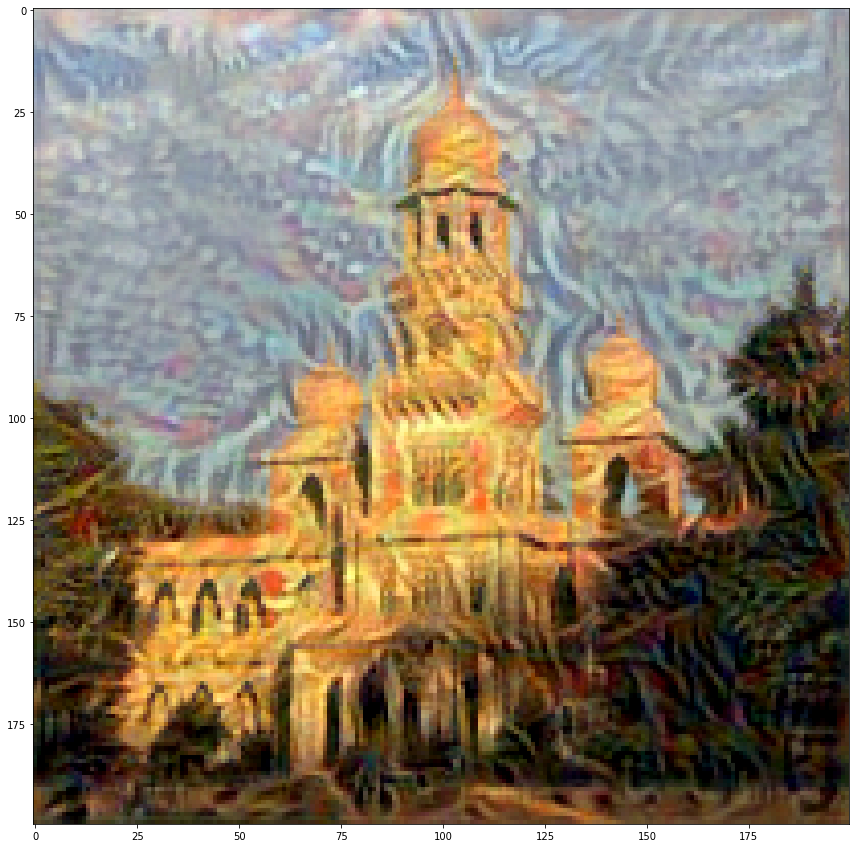

In [ ]:
best_generated_image = Get_Orignal(best_image)
plt.figure(figsize=(15,15))
plt.imshow(images[5])

In [ ]:
len(images)

15